# Siamese One-Shot-Learning Network, AT&T Faces Using [ReNom](https://www.renom.jp/)

In [1]:
import os
import codecs
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import random
import datetime
import time

In [2]:
import renom as rm
from renom.optimizer import Adam
from renom.utility import *
from renom.utility.distributor.imageloader import ImageLoader
from renom.cuda import set_cuda_active

## Set Configs

In [3]:
TRAIN_DIR = './datasets/faces/training/'
TEST_DIR = './datasets/faces/testing/'
BATCH_SIZE = 64
N_EPOCHS = 100
LR = 5e-4
N_GPU = 1

In [4]:
# check cuda availability
if rm.cuda.has_cuda() and N_GPU > 0: set_cuda_active(activate=True)
else: set_cuda_active(activate=False) 

## Set Helpers

In [5]:
def show_img(img, text=None, figsize=(20,20), should_save=False):
    
    plt.figure(figsize=figsize)
    plt.axis('off')
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10 })
    plt.imshow(img, cmap='gray')
    plt.show()

## Configure Custom Data Generator *

In [6]:
class SiameseNetDataGenerator(object):
    
    def __init__(self, datasets, should_invert=True):
        self.datasets = datasets
        self.should_invert = should_invert
    
    def generate(self, train=True):
        while True:
            imageA_tupple = random.choice(self.datasets)
            should_get_same_class = random.randint(0,1) # make sure approx 50% of images are in the same class
            if should_get_same_class:
                while True:
                    # keep looping until the same class image is found
                    imageB_tupple = random.choice(self.datasets)
                    if imageA_tupple[1] == imageB_tupple[1]:
                        break
            else:
                while True:
                    # keep looping until the different class image is found
                    imageB_tupple = random.choice(self.datasets)
                    if imageA_tupple[1] != imageB_tupple[1]:
                        break

            imageA = Image.open(imageA_tupple[0])
            imageB = Image.open(imageB_tupple[0])

            # the L means that it is just stores the Luminance
            imageA = imageA.convert('L')
            imageB = imageB.convert('L')

            if self.should_invert:
                imageA = ImageOps.invert(imageA)
                imageB = ImageOps.invert(imageB)

            # return image A, image B and its similarity score (label)
            yield imageA, imageB, np.array([int(imageA_tupple[1] != imageB_tupple[1])], dtype=np.float32)

In [7]:
def load_datasets(path_dir):
    datasets = list()
    train_list = [label for label in os.listdir(path_dir) if label != 'README']
    for idx_train, train in enumerate(train_list):
        image_list = os.listdir(path_dir + train)
        for image in image_list:
            datasets.append((path_dir + train + '/'  + image, idx_train))
            
    return datasets

In [8]:
datasets = load_datasets(path_dir=TRAIN_DIR)
siamese_generator = SiameseNetDataGenerator(datasets=datasets, should_invert=False)

## Visualize Data

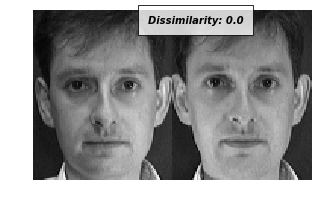

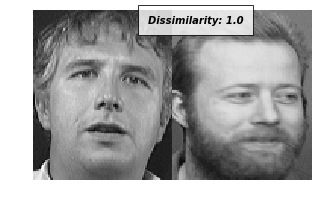

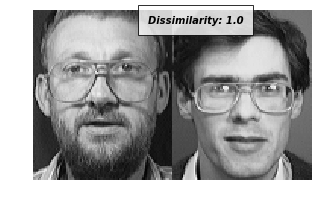

In [9]:
for _ in range(3):
    imageA, imageB, label = siamese_generator.generate(True).__next__()
    imageA = np.array(imageA)
    imageB = np.array(imageB)

    stacked_image = np.hstack((imageA, imageB))
    show_img(stacked_image, text="Dissimilarity: {}".format(label[0]), figsize=(5,5))

## Build [Siamese Network](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) Architecture *

In [10]:
class SiameseNet(rm.Model):
    
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.conv_layer = rm.Sequential([
            rm.Conv2d(channel=4, filter=3, padding=1),
            rm.Relu(),
            rm.BatchNormalize(),
            
            rm.Conv2d(channel=8, filter=3, padding=1),
            rm.Relu(),
            rm.BatchNormalize(),
            
            rm.Conv2d(channel=8, filter=3, padding=1),
            rm.Relu(),
            rm.BatchNormalize(),
        ])
        
        self.fc_layer = rm.Sequential([
            rm.Dense(500),
            rm.Relu(),
            
            rm.Dense(500),
            rm.Relu(),
            
            rm.Dense(5)
        ])
        
    def forward_once(self, x):
        x = self.conv_layer(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc_layer(x)
        
        return x
    
    def forward(self, imageA, imageB):
        resultA = self.forward_once(imageA)
        resultB = self.forward_once(imageB)
        
        return resultA, resultB

In [11]:
siamese = SiameseNet()

In [12]:
imageA = np.zeros((64, 8, 100, 100))
imageB = np.ones((64, 8, 100, 100))

resultA, resultB = siamese(imageA, imageB)

In [13]:
resultA.shape

(64, 5)

---